Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.
Epoch 1/10
200/200 [==============================] - 3s 10ms/step - loss: 1.3587 - accuracy: 0.3378 - val_loss: 1.2547 - val_accuracy: 0.4850
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0832 - accuracy: 0.5353 - val_loss: 0.9186 - val_accuracy: 0.5806
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8544 - accuracy: 0.6361 - val_loss: 0.7526 - val_accuracy: 0.6681
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7187 - accuracy: 0.6992 - val_loss: 0.6502 - val_accuracy: 0.7256
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6391 - accuracy: 0.7378 - val_loss: 0.6163 - val_accuracy: 0.7350
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5767 - accuracy: 0.7706 - 

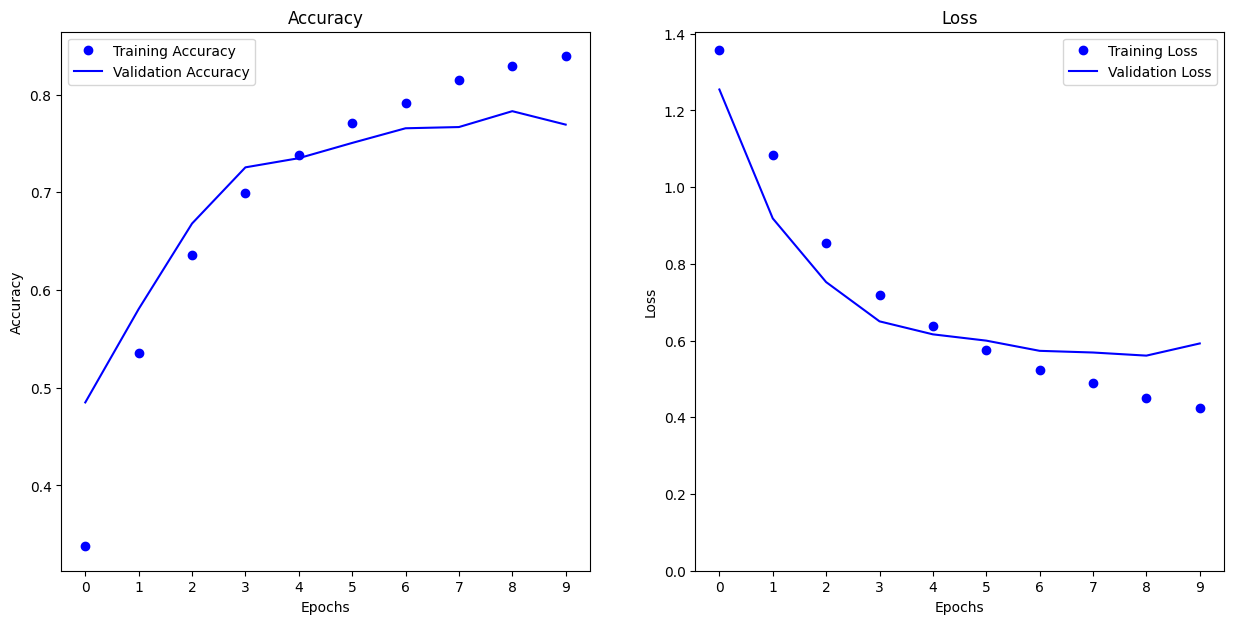

In [6]:
import numpy as np
import tensorflow as tf
import os, re, shutil, string
import matplotlib.pyplot as plt
import tarfile

#url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
#ds = tf.keras.utils.get_file('stack_overflow_16k', url, untar=True, cache_dir='.', cache_subdir='')

#file = tarfile.open('stack_overflow_16k.tar.gz').extractall('./stack_overflow_16k')\

batch, seed = 32, 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch,
    validation_split=0.2,
    subset='training', 
    seed=seed
)

raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch
)


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped = tf.strings.regex_replace(lowercase, '\n', ' ')
    #stripped = lowercase
    return tf.strings.regex_replace(stripped, '[%s]' % re.escape(string.punctuation), '')
    #return stripped

for text, label in raw_train_ds.take(1): 
    break
    for i in range(3):
        print('\n')
        print(custom_standardization(text.numpy()[i]))
        print(label.numpy()[i])

max_feat = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=sequence_length
)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

embedding_dims = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_feat+1, embedding_dims),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.18),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(4)
])

model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 10
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)
loss, accuracy = model.evaluate(test_ds, verbose=2)
hist_dict = hist.history

acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
epochs_range=range(epochs)
def make_plot():
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.title("Accuracy")
    plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(10))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    plt.plot(epochs_range, loss, 'bo', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
    plt.ylim(0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(10))
    #plt.yticks(np.arange(0, 1, 0.1))
    plt.legend()
make_plot()

exported_model = tf.keras.Sequential([ 
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

exported_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer='adam', metrics=['accuracy'])

#exported_model.predict(test_ds)